# Time series classification using functional logistic regression in binary and multiclass variants

## 0. Necessary imports

In [2]:
import os
from typing import List

from skfda.representation.basis import BSpline
from skfda.ml.classification import LogisticRegression
from skfda.datasets import make_gaussian_process
from sklearn.model_selection import train_test_split

from scipy.io import wavfile
from scipy.fft import fft, fftfreq

import numpy as np
import matplotlib.pyplot as plt

from multiclass_logistic_regression import MulticlassLogisticRegression
from wav_utils import create_wav_fdatagrid, transform_time_to_fft


In [37]:
LIGHT = '#B3FFFF' #179, 255, 255,

LIGHT_HIGHLIGHT= '#9AF6FF' #154, 246,255

MID = '#67C3FF'#103,195,255

MID_HIGHLIGHT = '#3490CC' #52,144,204

DARK = '#015D99' #1,93,153

DARK_HIGHLIGHT = '#002A66' #0,42,102

GREEN="#00FF00" # RGB

LIGHT_GREY="#DDDDDD" # RGB

## 1. Classification demo
Made with use of generated dataset to show accuracy of logistic regression in both variants.
Three datasets generated by gaussian process were prepared - each with different bias/mean component and random state - then concatenated and classified by prepared models.


In [2]:
# Specify number of samples for each dataset and number of features for each sample
n_samples = 100
n_features = 200

# Prepare 3 functional datasets
fd1 = make_gaussian_process(
        n_samples=n_samples,
        n_features=n_features,
        noise=0.7,
        random_state=0,
)
fd2 = make_gaussian_process(
        n_samples=n_samples,
        n_features = n_features,
        mean = np.array([1]*n_features),
        noise = 0.7,
        random_state=10
)
fd3 = make_gaussian_process(
        n_samples=n_samples,
        n_features = n_features,
        mean = np.array([2]*n_features),
        noise = 0.7,
        random_state=50
)

# Combine datasets and prepare labels
fd_binary = fd1.concatenate(fd2)
fd_multiclass = fd1.concatenate(fd2).concatenate(fd3)
y_binary = 100*[0] + 100*[1]
y_multiclass = 100*[0] + 100*[1] + 100*[2]

# Make models and train them (using half of samples for fitting process)
lr = LogisticRegression()
mlr = MulticlassLogisticRegression()

_ = lr.fit(fd_binary[::2], y_binary[::2])
_ = mlr.fit(fd_multiclass[::2], y_multiclass[::2])

# Show the results - using another half of samples for evaluation
lr_acc = lr.score(fd_binary[1::2], y_binary[1::2])
mlr_acc = mlr.score(fd_multiclass[1::2], y_multiclass[1::2])

print(f'''
Variant:      Binary                       Multiclass
Points:       {lr.points_.round(2)}   {mlr.points_.round(2)}
Accuracy:     {lr_acc:.2}                         {mlr_acc:.2}

Coefficients (Binary):
{lr.coef_.round(2)} 

Coefficients (Multiclass):
{mlr.coef_.round(2)}
''')

# Optional - print probability of each prediction
# print(mlr.predict_proba(fd_multiclass[1::2]).round(2))



Variant:      Binary                       Multiclass
Points:       [0.05 0.1  0.02 0.46 0.14]   [0.02 0.08 0.02 0.01 0.05]
Accuracy:     0.91                         0.89

Coefficients (Binary):
[[1.78 1.41 1.74 0.99 1.1 ]] 

Coefficients (Multiclass):
[[-1.6  -1.21 -1.36 -1.28 -1.29]
 [ 0.14  0.28 -0.46 -0.1   0.21]
 [ 1.45  0.93  1.82  1.38  1.08]]



## 2. Real example - sound recordings
A dataset of damaged drills sound recordings was used. Five datasets were prepared - each containing 30 samples of 1 second long recordings.  
Dataset comes from article: A. Glowacz, "Recognition of Acoustic Signals of Commutator Motors", Krakow 2018

### 2.1. Data preparation
Data is loaded, transformed into Fourier domain and normalized.  
Then with use of basis splines data is transformed into functional version on which functional logistic regression models can operate - from this moment each serie is considered as a whole instead of taking each sample separately.

In [3]:
dir_10 = '../resources/wiertarka/CM_10_zabkow_wiatrak/'
dir_5 = '../resources/wiertarka/CM_5_zabkow_wiatrak/'
dir_2 = '../resources/wiertarka/CM_2zeby_wentylator/'
dir_1 = '../resources/wiertarka/CM_1zab.czarny/'
dir_up = '../resources/wiertarka/CM_uszk_przekladnia/'

# load data and create data grids
fd_10 = create_wav_fdatagrid(dir_10)
fd_5 = create_wav_fdatagrid(dir_5)
fd_2 = create_wav_fdatagrid(dir_2)
fd_1 = create_wav_fdatagrid(dir_1)
fd_up = create_wav_fdatagrid(dir_up)

# fft transform
fd_10_fft = transform_time_to_fft(fd_10, normalize=True)
fd_5_fft = transform_time_to_fft(fd_5, normalize=True)
fd_2_fft = transform_time_to_fft(fd_2, normalize=True)
fd_1_fft = transform_time_to_fft(fd_1, normalize=True)
fd_up_fft = transform_time_to_fft(fd_up, normalize=True)


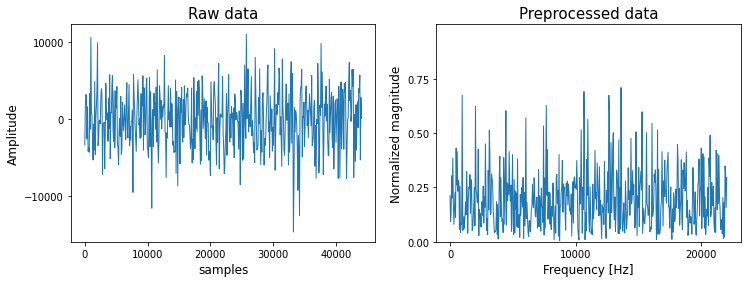

In [23]:
fd_one = fd_up[0]
fd_fft_one = fd_up_fft[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fd_one.plot(linewidth=1, axes=axes[0])
fd_fft_one.plot(linewidth=1, axes=axes[1])

axes[0].set_title("Raw data", fontsize=15)
axes[0].set_xlabel('samples', fontsize=12)
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].xaxis.set_ticks(np.arange(0, 44000, 10000))
axes[0].yaxis.set_ticks(np.arange(-10000, 10001, 10000))

axes[1].set_title("Preprocessed data", fontsize=15)
axes[1].set_xlabel('Frequency [Hz]', fontsize=12)
axes[1].set_ylabel('Normalized magnitude', fontsize=12)
axes[1].xaxis.set_ticks(np.arange(0, 23000, 10000))
axes[1].yaxis.set_ticks(np.arange(0, 1, 0.25))
axes[1].set_ylim([0, 1])

plt.savefig("../docs/imgs/common_preprocessing.eps", dpi=300, bbox_inches='tight')

# extent = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('../docs/imgs/common_preprocessing_before.eps', bbox_inches=extent.expanded(1.1, 1.2), dpi=300)

# extent = axes[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig('../docs/imgs/common_preprocessing_after.eps', bbox_inches=extent.expanded(1.1, 1.2), dpi=300)

plt.show()

### 2.2. Binary variant

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


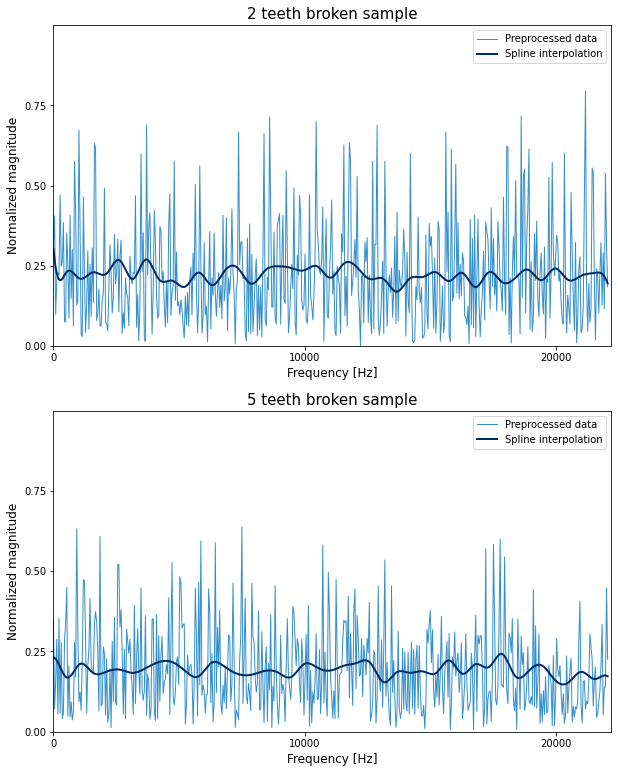

In [153]:
# Choose two classes/datasets:
fd1 = fd_2_fft
fd2 = fd_5_fft

# Set labels for final visualisations:
# (First label has to be longer than or equal to the second due to a bug in skfda lib, will be fixed in the future):
fd1_label = '2 teeth broken'
fd2_label = '5 teeth broken'

# Dataset concatenation:
fd = fd1.concatenate(fd2)

# Basis spline data interpolation - number of basis functions can be chosen (at least 5 due to spline 4th order)
bss = BSpline(n_basis=45)
fd_basis = fd.to_basis(bss).to_grid()



fig, axes = plt.subplots(2, 1, figsize=(10, 13))
fd[0].plot(linewidth=1, axes=axes[0], group=0, group_colors=[MID_HIGHLIGHT])
fd_basis[0].plot(linewidth=2, axes=axes[0], group=0, group_colors=[DARK_HIGHLIGHT])
fd[40].plot(linewidth=1, axes=axes[1], group=0, group_colors=[MID_HIGHLIGHT])
fd_basis[40].plot(linewidth=2, axes=axes[1], group=0, group_colors=[DARK_HIGHLIGHT])


axes[0].set_title(fd1_label + " sample", fontsize=15)
axes[0].set_xlabel('Frequency [Hz]', fontsize=12)
axes[0].set_ylabel('Normalized magnitude', fontsize=12)
axes[0].legend(['Preprocessed data', 'Spline interpolation'])
axes[0].xaxis.set_ticks(np.arange(0, 23000, 10000))
axes[0].yaxis.set_ticks(np.arange(0, 1, 0.25))
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, 22200])

axes[1].set_title(fd2_label + " sample", fontsize=15)
axes[1].set_xlabel('Frequency [Hz]', fontsize=12)
axes[1].set_ylabel('Normalized magnitude', fontsize=12)
axes[1].legend(['Preprocessed data', 'Spline interpolation'])
axes[1].xaxis.set_ticks(np.arange(0, 23000, 10000))
axes[1].yaxis.set_ticks(np.arange(0, 1, 0.25))
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 22200])

plt.savefig("../docs/imgs/combined_data_with_splines.eps", dpi=300, bbox_inches='tight')
plt.show()

In [139]:
# Binary logistic regression model fitting

fd_size = fd_basis.n_samples
y = fd_size//2*[0] + fd_size//2*[1];

# Splitting with help of scikit-learn function:
x_train, x_val, y_train, y_val = train_test_split(fd_basis, y, test_size=0.3, random_state=50, shuffle=True)

# Or splitting on two exact parts - may work better with small datasets as this one
# x_train = fd_basis[::2]
# x_val = fd_basis[1::2]The
# y_train = y[::2]
# y_val = y[1::2]

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
y_pred_proba = model.predict_proba(x_val)
print('true labels: ', np.array(y_val))
print('pred labels: ', y_pred)
print("Model accuracy: ", model.score(x_val, y_val))

# Optionally print the probabilities - all around 45-55%, so the model isn't sure in choosing classes. 
# Probably more samples are needed
print(f'[{fd1_label}, {fd2_label}]\n', y_pred_proba.round(4))

true labels:  [0 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1]
pred labels:  [1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1]
Model accuracy:  0.8888888888888888
[2 teeth broken, 5 teeth broken]
 [[0.4958 0.5042]
 [0.541  0.459 ]
 [0.4988 0.5012]
 [0.5381 0.4619]
 [0.525  0.475 ]
 [0.5086 0.4914]
 [0.5134 0.4866]
 [0.4754 0.5246]
 [0.5009 0.4991]
 [0.4756 0.5244]
 [0.5193 0.4807]
 [0.4839 0.5161]
 [0.479  0.521 ]
 [0.5196 0.4804]
 [0.4938 0.5062]
 [0.4878 0.5122]
 [0.5186 0.4814]
 [0.4947 0.5053]]


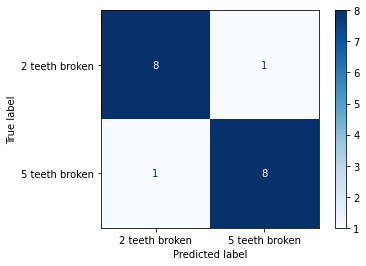

In [140]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(np.array(y_val), y_pred, cmap='Blues', display_labels=[fd1_label, fd2_label])
plt.savefig("../docs/imgs/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


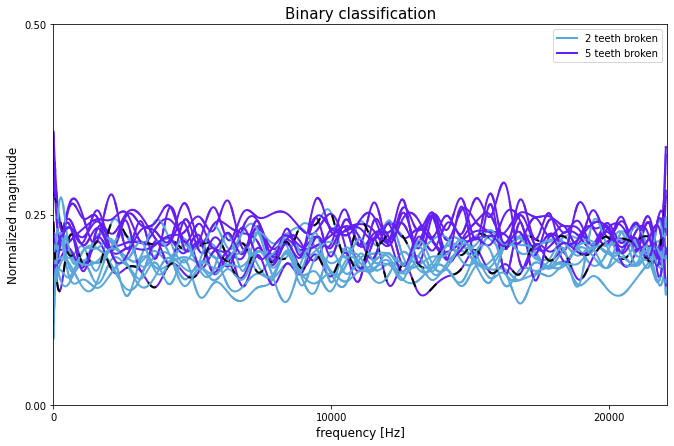

In [142]:
# Visualization
labels_pred = np.full(len(y_pred), fd1_label)
labels_pred[y_pred==1] = fd2_label

labels_wrong = np.copy(labels_pred)
labels_wrong[y_pred != y_val] = 'wrong'
colors = {
    fd1_label: '#641df2',
    fd2_label: '#5aa8db',
    'wrong': 'black'
}

fig, ax = plt.subplots(1, figsize=(11, 7))
x_val.plot(
    axes=ax,
    group=labels_pred,
    group_colors=colors,
    linewidth=2,
)

x_val.plot(
    axes=ax,
    group=labels_wrong,
    group_colors=colors,
    linewidth=2,
    linestyle=(0, (5, 10))
)


ax.set_title("Binary classification", fontsize=15)
ax.set_xlabel('frequency [Hz]', fontsize=12)
ax.set_ylabel('Normalized magnitude', fontsize=12)
ax.legend([fd1_label, fd2_label])
ax.xaxis.set_ticks(np.arange(0, 23000, 10000))
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.25))
plt.ylim([0, 0.5])
plt.xlim([0, 22100])

plt.savefig("../docs/imgs/binary_classification.eps", dpi=300, bbox_inches='tight')
plt.show()

### 2.3. Multiclass variant

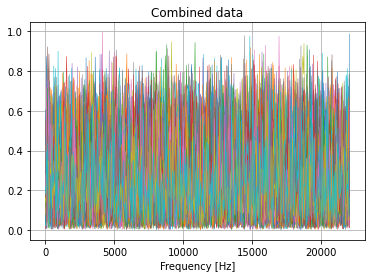

In [143]:
from multiclass_logistic_regression import MulticlassLogisticRegression

# Choose three or more classes/datasets:
fd1 = fd_up_fft
fd2 = fd_1_fft
fd3 = fd_2_fft

fd1_label = 'damaged gearing'
fd2_label = '1 tooth broken'
fd3_label = '2 teeth broken'

# Dataset concatenation:
fd = fd1.concatenate(fd2).concatenate(fd3)

fd.plot(linewidth=0.5)
plt.title("Combined data")
plt.xlabel("Frequency [Hz]")
plt.grid()
plt.show()

Number of separate functions in the dataset:  90


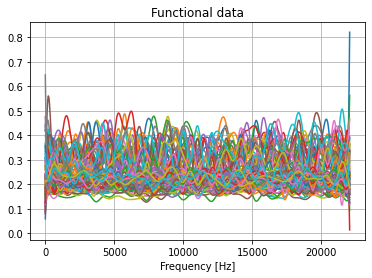

In [144]:
# Basis spline data interpolation - number of basis functions can be chosen (at least 5 due to spline 4th order)
bss = BSpline(n_basis=45)
fd_basis = fd.to_basis(bss).to_grid()

fd_basis.plot()
plt.title("Functional data")
plt.xlabel("Frequency [Hz]")
plt.grid()

print("Number of separate functions in the dataset: ", fd_basis.n_samples)
plt.show()

In [145]:
# Multiclass logistic regression model fitting

fd_size = fd_basis.n_samples
y = fd_size//3*[0] + fd_size//3*[1] + fd_size//3*[2]

# Splitting with help of scikit-learn function:
# x_train, x_val, y_train, y_val = train_test_split(fd_basis, y, test_size=0.3, random_state=55, shuffle=True)

# Or splitting on two exact parts - may work better with small datasets as this one
x_train = fd_basis[::3].concatenate(fd_basis[1::3])
x_val = fd_basis[2::3]
y_train = y[::3] + y[1::3]
y_val = y[2::3]

model = MulticlassLogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
y_pred_proba = model.predict_proba(x_val)

print('true labels: ', np.array(y_val))
print('pred labels: ', y_pred)
print("Model accuracy: ", model.score(x_val, y_val))

# Optionally print the probabilities - almost all around 25-35%, so the model isn't sure in choosing classes. 
# Probably more samples are needed.
print(f'[{fd1_label}, {fd2_label}]\n', y_pred_proba.round(4))

true labels:  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
pred labels:  [0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 2 0 0]
Model accuracy:  0.6666666666666666
[damaged gearing, 1 tooth broken]
 [[0.4444 0.1742 0.3814]
 [0.4383 0.1814 0.3804]
 [0.4499 0.1678 0.3824]
 [0.4078 0.219  0.3731]
 [0.4135 0.2119 0.3746]
 [0.4035 0.2252 0.3713]
 [0.3971 0.2329 0.37  ]
 [0.413  0.2125 0.3745]
 [0.4046 0.2226 0.3728]
 [0.411  0.2148 0.3742]
 [0.2596 0.4408 0.2995]
 [0.3428 0.308  0.3492]
 [0.1468 0.647  0.2063]
 [0.2935 0.3848 0.3217]
 [0.2315 0.4884 0.2801]
 [0.2831 0.4033 0.3137]
 [0.2188 0.5125 0.2687]
 [0.2926 0.3864 0.321 ]
 [0.2688 0.425  0.3062]
 [0.2593 0.4406 0.3001]
 [0.3839 0.2506 0.3656]
 [0.3952 0.2353 0.3695]
 [0.3653 0.276  0.3586]
 [0.3563 0.2889 0.3548]
 [0.3534 0.2933 0.3533]
 [0.3714 0.268  0.3606]
 [0.3913 0.2403 0.3684]
 [0.3521 0.2953 0.3526]
 [0.3623 0.281  0.3567]
 [0.3652 0.2766 0.3583]]


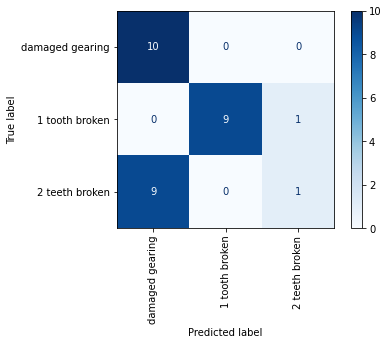

In [146]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(np.array(y_val), 
                                        y_pred, 
                                        cmap='Blues', 
                                        display_labels=[fd1_label, fd2_label, fd3_label],
                                        xticks_rotation='vertical')
plt.savefig("../docs/imgs/confusion_matrix_multiclass.png", dpi=300, bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


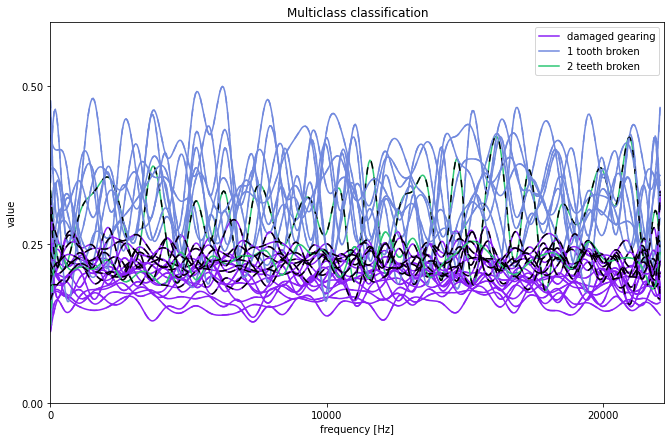

In [151]:
# Visualization
labels_pred = np.full(len(y_pred), fd1_label)
labels_pred[y_pred==1] = fd2_label
labels_pred[y_pred==2] = fd3_label

labels_wrong = np.copy(labels_pred)
labels_wrong[y_pred != y_val] = 'wrong'
colors = {
    fd1_label: '#8a20f5',
    fd2_label: '#7189de',
    fd3_label: '#2cc774',
    'wrong': 'black'
}

fig, ax = plt.subplots(1, figsize=(11, 7))
x_val.plot(
    axes=ax,
    group=labels_pred,
    group_colors=colors,
    linewidth=1.5,
)

x_val.plot(
    axes=ax,
    group=labels_wrong,
    group_colors=colors,
    linewidth=1.5,
    linestyle=(0, (5, 6))
)


ax.set_title("Multiclass classification")
ax.set(xlabel='frequency [Hz]', ylabel='value')
ax.legend([fd1_label, fd2_label, fd3_label])
ax.xaxis.set_ticks(np.arange(0, 23000, 10000))
ax.yaxis.set_ticks(np.arange(0, 0.6, 0.25))
leg = ax.get_legend()
leg.legendHandles[0].set_color(colors[fd1_label])
leg.legendHandles[1].set_color(colors[fd2_label])
leg.legendHandles[2].set_color(colors[fd3_label])
plt.ylim([0, 0.6])
plt.xlim([0, 22200])


plt.savefig("../docs/imgs/multiclass_classification.eps", dpi=300, bbox_inches='tight')
plt.show()